## Import Libraries

In [11]:
import torch
import torch.nn as nn
import numpy as np
from collections import OrderedDict
from utils import Sine_Task, Sine_Task_Distribution
import matplotlib.pyplot as plt

## Model

In [12]:
class MAMLModel(nn.Module):
    def __init__(self):
        super(MAMLModel, self).__init__()
        # 1 -> 40 -> 40 -> 1
        # OrderedDict : 삽입된 순서대로 획득 가능..!! 
        self.model = nn.Sequential(OrderedDict([
            ('l1', nn.Linear(1,40)),
            ('relu1', nn.ReLU()),
            ('l2', nn.Linear(40,40)),
            ('relu2', nn.ReLU()),
            ('l3', nn.Linear(40,1))
        ]))
        
    def forward(self, x):
        return self.model(x)
    
    def parameterised(self, x, weights):
        # like forward, but uses ``weights`` instead of ``model.parameters()``
        # it'd be nice if this could be generated automatically for any nn.Module...
        x = nn.functional.linear(x, weights[0], weights[1])
        x = nn.functional.relu(x)
        x = nn.functional.linear(x, weights[2], weights[3])
        x = nn.functional.relu(x)
        x = nn.functional.linear(x, weights[4], weights[5])
        return x
                        

In [13]:
model = MAMLModel()
for i in list(model.parameters()):
    print(i.shape)

torch.Size([40, 1])
torch.Size([40])
torch.Size([40, 40])
torch.Size([40])
torch.Size([1, 40])
torch.Size([1])


## MAML

In [14]:
class MAML():
    def __init__(self, model, tasks, inner_lr, meta_lr, K=10, inner_steps=1, tasks_per_meta_batch=1000):
        
        # important objects
        self.tasks = tasks
        self.model = model
        self.weights = list(model.parameters()) # the maml weights we will be meta-optimising
        self.criterion = nn.MSELoss()
        self.meta_optimiser = torch.optim.Adam(self.weights, meta_lr)
        
        # hyperparameters
        self.inner_lr = inner_lr
        self.meta_lr = meta_lr
        self.K = K
        self.inner_steps = inner_steps # with the current design of MAML, >1 is unlikely to work well 
        self.tasks_per_meta_batch = tasks_per_meta_batch 
        
        # metrics
        self.plot_every = 10
        self.print_every = 500
        self.meta_losses = []
    
    def inner_loop(self, task):
        # reset inner model to current maml weights
        temp_weights = [w.clone() for w in self.weights]
        
        # perform training on data sampled from task
        X, y = task.sample_data(self.K)
        for step in range(self.inner_steps):
            loss = self.criterion(self.model.parameterised(X, temp_weights), y) / self.K
            
            # compute grad and update inner loop weights
            grad = torch.autograd.grad(loss, temp_weights)
            temp_weights = [w - self.inner_lr * g for w, g in zip(temp_weights, grad)]
        
        # sample new data for meta-update and compute loss
        X, y = task.sample_data(self.K)
        loss = self.criterion(self.model.parameterised(X, temp_weights), y) / self.K
        
        return loss
    
    def main_loop(self, num_iterations):
        epoch_loss = 0
        
        for iteration in range(1, num_iterations+1):
            
            # compute meta loss
            meta_loss = 0
            for i in range(self.tasks_per_meta_batch):
                task = self.tasks.sample_task()
                meta_loss += self.inner_loop(task)
            
            # compute meta gradient of loss with respect to maml weights
            meta_grads = torch.autograd.grad(meta_loss, self.weights)
            
            # assign meta gradient to weights and take optimisation step
            for w, g in zip(self.weights, meta_grads):
                w.grad = g
            self.meta_optimiser.step()
            
            # log metrics
            epoch_loss += meta_loss.item() / self.tasks_per_meta_batch
            
            if iteration % self.print_every == 0:
                print("{}/{}. loss: {}".format(iteration, num_iterations, epoch_loss / self.plot_every))
            
            if iteration % self.plot_every == 0:
                self.meta_losses.append(epoch_loss / self.plot_every)
                epoch_loss = 0

In [15]:
tasks = Sine_Task_Distribution(0.1, 5, 0, np.pi, -5, 5)
maml = MAML(MAMLModel(), tasks, inner_lr=0.01, meta_lr=0.001)

In [17]:
maml.main_loop(num_iterations=10000)

500/10000. loss: 0.2778207061767578
1000/10000. loss: 0.25743925323486333
1500/10000. loss: 0.24042072601318357
2000/10000. loss: 0.1758679946899414
2500/10000. loss: 0.10332258071899414
3000/10000. loss: 0.08265519409179686
3500/10000. loss: 0.07723113174438476
4000/10000. loss: 0.07167054901123046
4500/10000. loss: 0.06974857940673829
5000/10000. loss: 0.06636966400146485
5500/10000. loss: 0.06397886962890625
6000/10000. loss: 0.05857086715698243
6500/10000. loss: 0.057140478897094726
7000/10000. loss: 0.053444585418701174
7500/10000. loss: 0.054995672225952155
8000/10000. loss: 0.05490728492736816
8500/10000. loss: 0.053408934402465816
9000/10000. loss: 0.051579615020751944
9500/10000. loss: 0.05431940994262695
10000/10000. loss: 0.053900854110717766


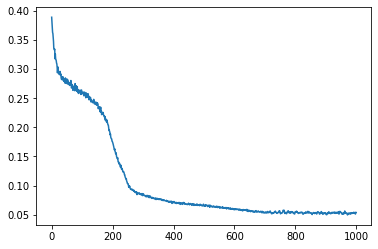

In [18]:
plt.plot(maml.meta_losses)

## Testing and Plotting

In [19]:
def loss_on_random_task(initial_model, K, num_steps, optim=torch.optim.SGD):
    """
    trains the model on a random sine task and measures the loss curve.
    
    for each n in num_steps_measured, records the model function after n gradient updates.
    """
    
    # copy MAML model into a new object to preserve MAML weights during training
    model = nn.Sequential(OrderedDict([
        ('l1', nn.Linear(1,40)),
        ('relu1', nn.ReLU()),
        ('l2', nn.Linear(40,40)),
        ('relu2', nn.ReLU()),
        ('l3', nn.Linear(40,1))
    ]))
    model.load_state_dict(initial_model.state_dict())
    criterion = nn.MSELoss()
    optimiser = optim(model.parameters(), 0.01)

    # train model on a random task
    task = tasks.sample_task()
    X, y = task.sample_data(K)
    losses = []
    for step in range(1, num_steps+1):
        loss = criterion(model(X), y) / K
        losses.append(loss.item())

        # compute grad and update inner loop weights
        model.zero_grad()
        loss.backward()
        optimiser.step()
        
    return losses

In [20]:
def average_losses(initial_model, n_samples, K=10, n_steps=10, optim=torch.optim.SGD):
    """
    returns the average learning trajectory of the model trained for ``n_iterations`` over ``n_samples`` tasks
    """
    avg_losses = [0] * n_steps
    for i in range(n_samples):
        losses = loss_on_random_task(initial_model, K, n_steps, optim)
        avg_losses = [l + l_new for l, l_new in zip(avg_losses, losses)]
    avg_losses = [l / n_samples for l in avg_losses]
    
    return avg_losses

In [25]:
def mixed_pretrained(iterations=500):
    """
    returns a model pretrained on a selection of ``iterations`` random tasks.
    """
    device = torch.device('cuda:0')
    # set up model
    model = nn.Sequential(OrderedDict([
            ('l1', nn.Linear(1,40)),
            ('relu1', nn.ReLU()),
            ('l2', nn.Linear(40,40)),
            ('relu2', nn.ReLU()),
            ('l3', nn.Linear(40,1))
        ]))
    model = model.to(device)
    optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    # fit the model
    for i in range(1,iterations+1):
        model.zero_grad()
        x, y = tasks.sample_task().sample_data(10)
        x = x.to(device)
        y = y.to(device)
        loss = criterion(model(x), y)
        loss.backward()
        optimiser.step()
        if i % 500 == 0:
            print("{}/{} Clear".format(i,iterations))
    return model

In [26]:
pretrained = mixed_pretrained(10000)

500/10000 Clear
1000/10000 Clear
1500/10000 Clear
2000/10000 Clear
2500/10000 Clear
3000/10000 Clear
3500/10000 Clear
4000/10000 Clear
4500/10000 Clear
5000/10000 Clear
5500/10000 Clear
6000/10000 Clear
6500/10000 Clear
7000/10000 Clear
7500/10000 Clear
8000/10000 Clear
8500/10000 Clear
9000/10000 Clear
9500/10000 Clear
10000/10000 Clear


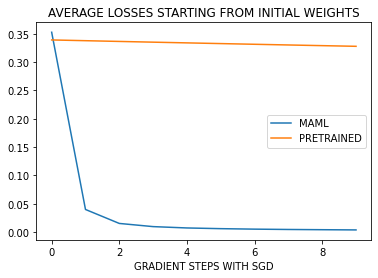

In [27]:
plt.figure()
plt.plot(average_losses(maml.model.model, n_samples=5000, K=10), label='MAML')
plt.plot(average_losses(pretrained,       n_samples=5000, K=10), label='PRETRAINED')
plt.legend()
plt.title("AVERAGE LOSSES STARTING FROM INITIAL WEIGHTS")
plt.xlabel("GRADIENT STEPS WITH SGD")
plt.show()

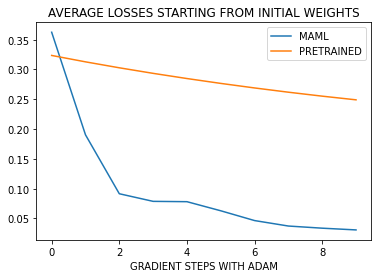

In [28]:
plt.figure()
plt.plot(average_losses(maml.model.model, n_samples=5000, K=10, optim=torch.optim.Adam), label='MAML')
plt.plot(average_losses(pretrained,       n_samples=5000, K=10, optim=torch.optim.Adam), label='PRETRAINED')
plt.legend()
plt.title("AVERAGE LOSSES STARTING FROM INITIAL WEIGHTS")
plt.xlabel("GRADIENT STEPS WITH ADAM")
plt.show()

In [71]:
def model_functions_at_training(initial_model, X, y, sampled_steps, x_axis, optim=torch.optim.SGD, lr=0.01):
    """
    trains the model on X, y and measures the loss curve.
    
    for each n in sampled_steps, records model(x_axis) after n gradient updates.
    """

    # copy MAML model into a new object to preserve MAML weights during training
    model = nn.Sequential(OrderedDict([
        ('l1', nn.Linear(1,40)),
        ('relu1', nn.ReLU()),
        ('l2', nn.Linear(40,40)),
        ('relu2', nn.ReLU()),
        ('l3', nn.Linear(40,1))
    ]))
    model.load_state_dict(initial_model.state_dict())
    criterion = nn.MSELoss()
    optimiser = optim(model.parameters(), lr)

    # train model on a random task
    num_steps = max(sampled_steps)
    K = X.shape[0]
    
    losses = []
    outputs = {}
    for step in range(1, num_steps+1):
        loss = criterion(model(X), y) / K
        losses.append(loss.item())

        # compute grad and update inner loop weights
        model.zero_grad()
        loss.backward()
        optimiser.step()

        # plot the model function
        if step in sampled_steps:
            outputs[step] = model(torch.tensor(x_axis, dtype=torch.float).view(-1, 1)).detach().numpy()
            
    outputs['initial'] = initial_model(torch.tensor(x_axis, dtype=torch.float).view(-1, 1)).detach().numpy()
    
    return outputs, losses

In [64]:
def plot_sampled_performance(initial_model, model_name, task, X, y, optim=torch.optim.SGD, lr=0.01):
    
    x_axis = np.linspace(-5, 5, 1000)
    sampled_steps=[1,5,15]
    outputs, losses = model_functions_at_training(initial_model, 
                                                  X, y, 
                                                  sampled_steps=sampled_steps, 
                                                  x_axis=x_axis, 
                                                  optim=optim, lr=lr)

    plt.figure(figsize=(20,5))
    
    # plot the model functions
    plt.subplot(1, 2, 1)
    plt.plot(x_axis, task.true_function(x_axis), '-', color=(0, 0, 1, 0.6), label='TRUE FUNCTION')
    plt.scatter(X, y, label='DATA')
    plt.plot(x_axis, outputs['initial'], ':', color=(0.7, 0, 0, 1), label='INITIAL MODEL')
    plt.plot(x_axis, outputs[1], '-.', color=(0, 0.7, 0, 1), label='AFTER 1 STEPS')
    plt.plot(x_axis, outputs[5], '--', color=(0, 0, 0.7, 1), label='AFTER 5 STEPS')
    plt.plot(x_axis, outputs[15], linestyle=(0,(3,1,1,1)), color='#FFD700', label='AFTER 15 STEPS')
    plt.legend(loc='lower right')
    plt.title("{}".format(model_name))

    # plot losses
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title("LOSSES")
    plt.xlabel("GRADIENT STEPS WITH SGD")
    plt.show()

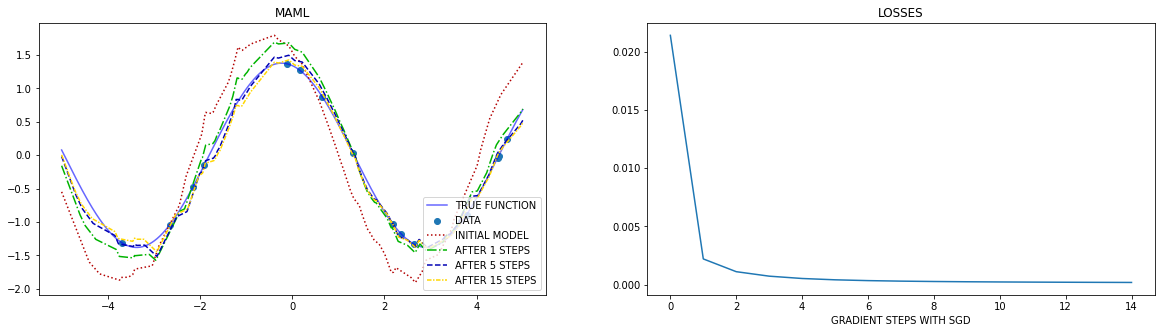

In [65]:
K = 15
task = tasks.sample_task()
X, y = task.sample_data(K)

plot_sampled_performance(maml.model.model, 'MAML', task, X, y)

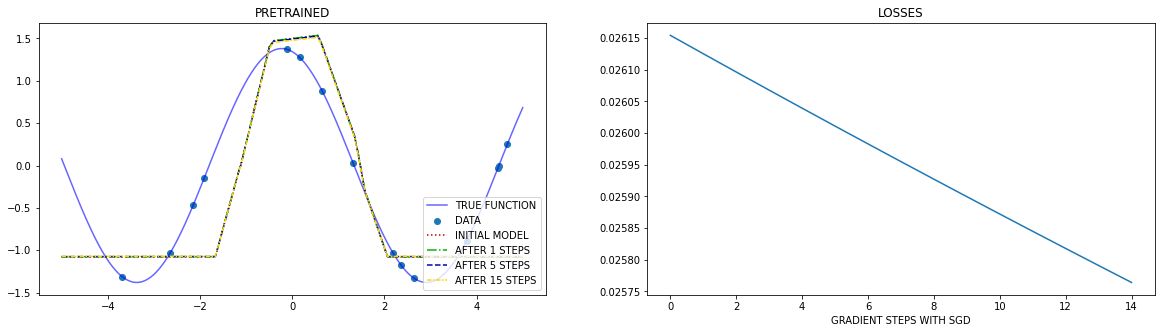

In [72]:
pretrained = pretrained.to(torch.device('cpu'))
plot_sampled_performance(pretrained, 'PRETRAINED', task, X, y, lr=0.01)

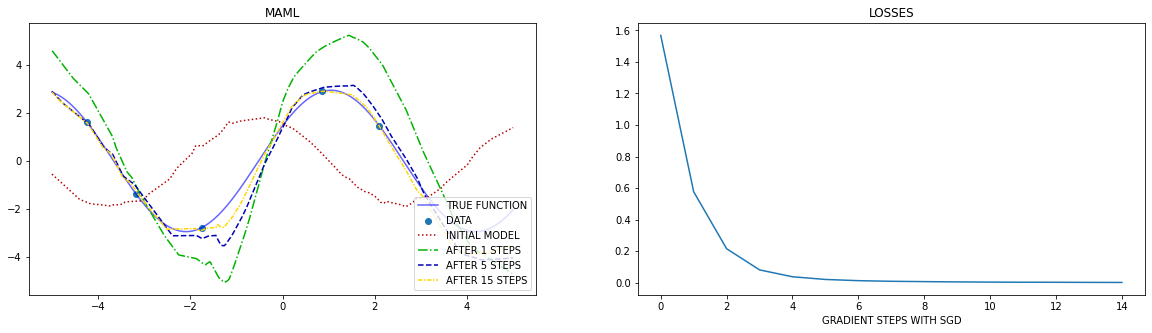

In [78]:
K = 5
task = tasks.sample_task()
X, y = task.sample_data(K)

plot_sampled_performance(maml.model.model, 'MAML', task, X, y)